### A/B тестирование: Эффективность рекомендательной системы


Цель проекта: провести оценку результатов A/B-теста и оценить, влияет ли рекомендательная система на вовлечение покупателей. 

### Загрузка дата-фреймов и предобратка данных 

In [149]:
#импортируем необходимые библиотеки
import pandas as pd
import numpy as np 
from scipy import stats
import matplotlib.pyplot as plt 
import seaborn as sns
import datetime as dt
import plotly.graph_objects as go
from statsmodels.stats.proportion import proportions_ztest

In [150]:
#загрузим сразу все дата-сеты

marketing_events = pd.read_csv('/datasets/ab_project_marketing_events.csv')
new_users = pd.read_csv('/datasets/final_ab_new_users.csv')
events = pd.read_csv('/datasets/final_ab_events.csv')
participants = pd.read_csv('/datasets/final_ab_participants.csv')

In [103]:
#изучим дата-сет marketing_events
marketing_events.head()

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


In [104]:
marketing_events.duplicated().sum()

0

In [105]:
marketing_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


In [106]:
#изменим тип данных

marketing_events['start_dt'] = pd.to_datetime(marketing_events['start_dt'])
marketing_events['finish_dt'] = pd.to_datetime(marketing_events['finish_dt'])
marketing_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 576.0+ bytes


In [107]:
#изучим дата-фрейм new_users

new_users.head()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


In [108]:
new_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


In [109]:
new_users.duplicated().sum()

0

In [110]:
#изучим дата-фрейм events

events.head ()

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


In [111]:
events.info ()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


In [112]:
events.duplicated().sum()

0

In [113]:
print (events['details'].describe())
print (events['details'].nunique ())

count    62740.000000
mean        23.877631
std         72.180465
min          4.990000
25%          4.990000
50%          4.990000
75%          9.990000
max        499.990000
Name: details, dtype: float64
4


In [114]:
print (events['details'].isnull().sum())
events['details'] = events['details'].fillna(0)
events['details'].info()

377577
<class 'pandas.core.series.Series'>
RangeIndex: 440317 entries, 0 to 440316
Series name: details
Non-Null Count   Dtype  
--------------   -----  
440317 non-null  float64
dtypes: float64(1)
memory usage: 3.4 MB


Вывод: Пропуски в этой колонке, скорее всего, говорят о том, что эти люди не платили ничего, и продолжали пользоваться продуктом бесплатно. Соответствнно, мы можем заменить их на 0, чтобы было удобнее в случае подсчета. 

In [115]:
events['event_dt'] = pd.to_datetime(events['event_dt'])
events.info ()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     440317 non-null  object        
 1   event_dt    440317 non-null  datetime64[ns]
 2   event_name  440317 non-null  object        
 3   details     440317 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 13.4+ MB


In [116]:
#изучим дата-фрейм participants

participants.head()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


In [117]:
print (participants ['ab_test'].unique())
print (participants ['group'].unique())

['recommender_system_test' 'interface_eu_test']
['A' 'B']


In [118]:
events.duplicated().sum()

0

In [119]:
participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


Вывод: Дата-фреймы, в целом, оказадись чистыми. Заменили по необходимости типы данных и заполнили пропуски. Можно переходить к непосредественному исследованию. 

### Оценка корректности проведения теста

- Посмотрим на:
    - Соответствие данных требованиям технического задания. Проверьте корректность всех пунктов технического задания.
    - Время проведения теста. Убедитесь, что оно не совпадает с маркетинговыми и другими активностями.
    - Аудиторию теста. Удостоверьтесь, что нет пересечений с конкурирующим тестом и нет пользователей, участвующих в двух группах теста одновременно. Проверьте равномерность распределения по тестовым группам и правильность их формирования.

In [120]:
# найдем пользователей, которые зарегистрировали с 7 по 21 декабря 2020 года
new_users_dates = new_users.query('first_date >= "2020-12-07" and first_date <= "2020-12-21"')

#найдем пользователей, у которых регион EU в нашем же временном промежутке 
eu_users = new_users_dates.query('region == "EU"')

print("Уникальных пользователей из EU, зарегистрировавшихся с 7 по 21 декабря 2020 года:", eu_users['user_id'].nunique())

Уникальных пользователей из EU, зарегистрировавшихся с 7 по 21 декабря 2020 года: 42340


In [121]:
# проверим пересечение по датам с маркетнинговыми активностями 

#введем переменные даты начала и конца проведения теста
test_sd = '2020-12-07'
test_ed = '2021-01-04'


cross_events = marketing_events.query('start_dt <= @test_ed and finish_dt >= @test_sd and "EU" in regions')
print(f"События, которые пересекаются с тестом по датам проведения теста: {cross_events}")


События, которые пересекаются с тестом по датам проведения теста: Empty DataFrame
Columns: [name, regions, start_dt, finish_dt]
Index: []


Вывод: условие технического задание выполнено - нет пересекающихся маркетинговых мероприятий. 

In [122]:
# проверим пересечения с конкурирующим тестом, для этого нам нужен датафрейм participants

#выберем участников recommender_system_test
recommender_participants = participants.query('ab_test == "recommender_system_test"')

# Проверка пересечений с конкурирующим тестом

cross_participants_test = recommender_participants ['user_id'].isin(participants.query('ab_test != "recommender_system_test"')['user_id'])

if cross_participants_test.sum() == 0:    
    print("Пересечений пользователей с конкурирующим тестом нет.")
else:    
    print(f"Количество пересечений с конкурирующим тестом: {cross_participants_test.sum()}")

Количество пересечений с конкурирующим тестом: 1602


In [123]:
#проверим наличие польхователей, одновременно участвующих в двух группах

duplicated_users = recommender_participants['user_id'].duplicated().sum()

if duplicated_users == 0:
    print("Пользователей, участвующих в двух группах теста одновременно, нет.")
else:
    print(f"Количество пользователей, участвующих в двух группах теста одновременно: {duplicated_users}")

Пользователей, участвующих в двух группах теста одновременно, нет.


In [124]:
# проверим, равномерно ли распределены пользователи по группам

group_count = recommender_participants.groupby('group')['user_id'].count()


print(f"Количество пользователей в каждой группе: {group_count}")

Количество пользователей в каждой группе: group
A    3824
B    2877
Name: user_id, dtype: int64


Группы распределены не совсем равномерно, что может сказаться на результатах теста. Будем использовать тест пропорций для сглаживания этой неточности. 

In [125]:
#проверим правильность формирования групп

total_test_users = recommender_participants['user_id'].nunique()
unique_eu_users = eu_users['user_id'].nunique()

print("Доля пользователей, участвующих в тесте:", round (total_test_users / unique_eu_users*100,2) )


Доля пользователей, участвующих в тесте: 15.83


Вывод: по результату оценки данных можем сказать, что данные соответствуют техническим требованиям проверки: 
- время проведения теста не пересекается с маркетинговыми активностями 
- пользоватили в выборках набрались с 7 по 21 декабря
- не обнаружены пересечения аудиторий с конкурирующим тестов
- нет пользователей, участвующих в двух группах 
- доля участвующих пользователей - 15,83% 

Соответствие данных требованиям технического задания. Проверьте корректность всех пунктов технического задания.
Время проведения теста. Убедитесь, что оно не совпадает с маркетинговыми и другими активностями.
Аудиторию теста. Удостоверьтесь, что нет пересечений с конкурирующим тестом и нет пользователей, участвующих в двух группах теста одновременно. Проверьте равномерность распределения по тестовым группам и правильность их формирования.

### Исследовательский анализ данных 

- Количество событий на пользователя одинаково распределены в выборках?
- Как число событий в выборках распределено по дням?
- Как меняется конверсия в воронке в выборках на разных этапах?
- Какие особенности данных нужно учесть, прежде чем приступать к A/B-тестированию?

In [126]:
#проверим количество событий на пользователя: одинаково ли они распределены в выборках

events_groups = events.merge(participants, on="user_id", how="inner")
event_counts = events_groups.groupby(["user_id", "group"])["event_name"].count().reset_index()

group_a = event_counts.query('group == "A"')
group_b = event_counts.query('group == "B"')

display (group_a)
display (group_b)

,user_id,group,event_name
0,0002CE61FF2C4011,A,12
2,0010A1C096941592,A,12
4,002412F1EB3F6E38,A,8
5,002540BE89C930FB,A,9
7,003346BB64227D0C,A,3
...,...,...,...
14067,FFC676CB3E0A60B8,A,6
14069,FFDA3BD9A090A179,A,6
14070,FFDC1BEFD27A66D5,A,2
14073,FFE600EEC4BA7685,A,6


,user_id,group,event_name
1,001064FEAAB631A1,B,12
3,001E72F50D1C48FA,B,6
6,0031F1B5E9FBF708,B,4
9,0036BE15EE4D319D,B,2
11,003F86A34B575D27,B,4
...,...,...,...
14072,FFE5B14BD55C1C5C,B,4
14074,FFE7FC140521F5F6,B,20
14075,FFEFC0E55C1CCD4F,B,4
14077,FFF28D02B1EACBE1,B,9


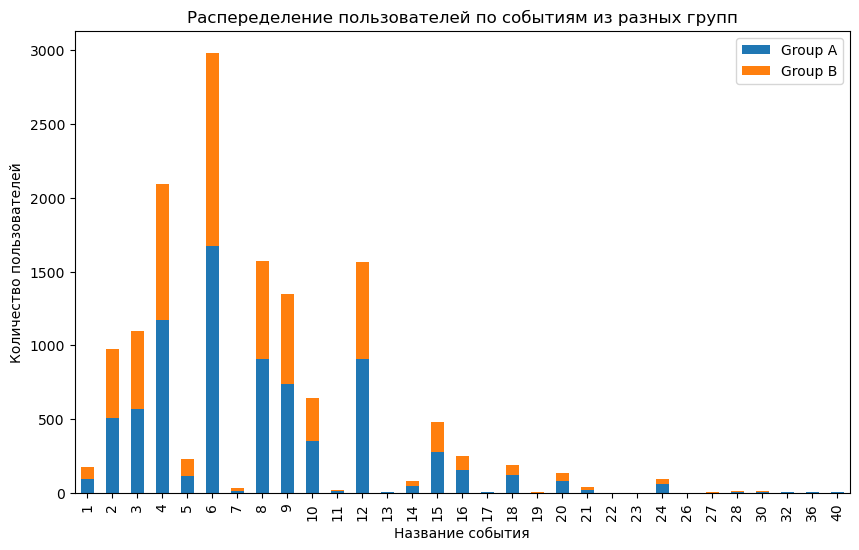

In [127]:
#считаем количество событий по названию событий
group_a_counts = group_a['event_name'].value_counts().sort_index()
group_b_counts = group_b['event_name'].value_counts().sort_index()

#делаем сводную таблицу 
groups_chart = pd.DataFrame({'Группа A': group_a_counts, 'Группа B': group_b_counts})

#строим график
ax = data.plot.bar(stacked=True, figsize=(10, 6))
ax.set_title('Распеределение пользователей по событиям из разных групп')
ax.set_xlabel('Название события')
ax.set_ylabel('Количество пользователей')
plt.show()


Вывод: самые популярные события 6, 4, 8, 12 и 9. Причем как для грцппы  А, так и для группы B. Самые не популярные - практически нет пользователей: 40. 36, 22, 23, 26. 
    

In [128]:
# посмотрим, как число событий в выборках распределено по дням

#выделим из event_dt только дату
events['event_dt'] = pd.to_datetime(events['event_dt']).dt.date

#объединим таблицы events и participants
events_participants = events.merge(participants, on='user_id', how='inner')
display (events_participants) 

,user_id,event_dt,event_name,details,group,ab_test
0,96F27A054B191457,2020-12-07,purchase,4.99,B,interface_eu_test
1,96F27A054B191457,2020-12-08,purchase,4.99,B,interface_eu_test
2,96F27A054B191457,2020-12-09,purchase,4.99,B,interface_eu_test
3,96F27A054B191457,2020-12-26,purchase,9.99,B,interface_eu_test
4,96F27A054B191457,2020-12-07,product_page,0.00,B,interface_eu_test
...,...,...,...,...,...,...
106620,40076B77CFC12421,2020-12-24,login,0.00,B,interface_eu_test
106621,40076B77CFC12421,2020-12-25,login,0.00,B,interface_eu_test
106622,40076B77CFC12421,2020-12-26,login,0.00,B,interface_eu_test
106623,301C602AF78BABAD,2020-12-23,login,0.00,B,interface_eu_test


In [129]:
#посчитаем количество участников групп по мероприятиям
events_daily = events_participants.groupby(['event_dt', 'group']).count().reset_index()
events_daily_group_a = events_daily.query('group == "A"')
events_daily_group_b = events_daily.query('group == "B"')
display (events_daily_group_a)

,event_dt,group,user_id,event_name,details,ab_test
0,2020-12-07,A,1375,1375,1375,1375
2,2020-12-08,A,1493,1493,1493,1493
4,2020-12-09,A,1557,1557,1557,1557
6,2020-12-10,A,1638,1638,1638,1638
8,2020-12-11,A,1672,1672,1672,1672
10,2020-12-12,A,2173,2173,2173,2173
12,2020-12-13,A,2335,2335,2335,2335
14,2020-12-14,A,3582,3582,3582,3582
16,2020-12-15,A,3294,3294,3294,3294
18,2020-12-16,A,3179,3179,3179,3179


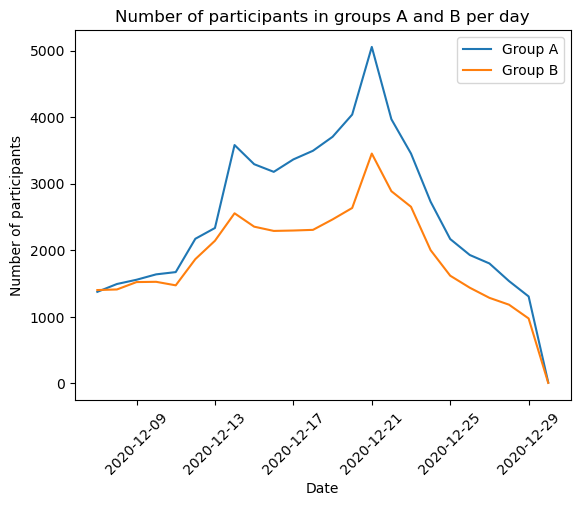

In [130]:

plt.plot(events_daily_group_a['event_dt'], events_daily_group_a['user_id'], label='Group A')
plt.plot(events_daily_group_b['event_dt'], events_daily_group_b['user_id'], label='Group B')
plt.xlabel('Даты ')
plt.ylabel('Количество участников')
plt.title('Количество участников в группах А и B по дням')
plt.xticks(rotation=45)
plt.legend()
plt.show()

Вывод: наиболее активный день, в который было наибольшее количество участников - 21 декабря, так же был пик 13 декабря. Наименьшее количество участников пришлось на самый конец теста - 29 декабря. 

In [144]:
#проверим, как меняется конверсия в воронке в выборках на разных этапах
#display (events_participants)
# создадтим таблицу для использования воронки
funnel_data = events_participants.groupby(['group', 'event_name']).count().reset_index().sort_values(by = 'group', ascending = False)
funnel_data_group_a = funnel_data[funnel_data['group'] == "A"].sort_values(by='user_id', ascending=False)
funnel_data_group_b = funnel_data[funnel_data['group'] == "B"].sort_values(by='user_id', ascending=False)



In [156]:
# создаем воронку
fig = go.Figure()

fig.add_trace(go.Funnel(
    name='Группа A',
    y=funnel_data_group_a['event_name'],
    x=funnel_data_group_a['user_id'],
    textinfo="value+percent initial"
))

fig.add_trace(go.Funnel(
    name='Группа B',
    y=funnel_data_group_b['event_name'],
    x=funnel_data_group_b['user_id'],
    textinfo="value+percent initial"
))

fig.update_layout(
    title= 'Воронка по событиям для групп А и В',
    width=800,
    height=500
)

fig.show()


Вывод: провели исследовательский анализ данных. 
1. Самые популярные события 6, 4, 8, 12 и 9. Причем как для грцппы А, так и для группы B. Самые не популярные - практически нет пользователей: 40. 36, 22, 23, 26.
2. Наиболее активный день, в который было наибольшее количество участников - 21 декабря, так же был пик 13 декабря. Наименьшее количество участников пришлось на самый конец теста - 29 декабря. 
3. Воронка наглядно показывает, насколько снижается количество участников в разрезе групп от регистрации до получения карты. 


### Анализ результатов теста
   - Что можно сказать про результаты A/В-тестирования?
   - Проверьте статистическую разницу долей z-критерием.

In [147]:
# объединим таблицы events и recommender_participants
merged_data = events.merge(recommender_participants, on='user_id')

# сгрурпирцем данные по пользователям и событиям 
user_events = merged_data.pivot_table(index=['user_id', 'group'], columns='event_name', values='event_dt', aggfunc='count', fill_value=0).reset_index()

display (user_events)

event_name,user_id,group,login,product_cart,product_page,purchase
0,001064FEAAB631A1,B,3,0,3,0
1,0010A1C096941592,A,4,0,4,4
2,00341D8401F0F665,A,2,0,0,0
3,003DF44D7589BBD4,A,5,5,5,0
4,00505E15A9D81546,A,5,0,0,0
...,...,...,...,...,...,...
3670,FF5B24BCE4387F86,A,3,0,3,3
3671,FF825C1D791989B5,A,4,4,0,0
3672,FF8CF7057415EB29,B,2,0,2,0
3673,FFAE9489C76F352B,A,3,0,3,0


In [154]:
alpha = 0.05 

print ('С поправкой Боннефоррни:', alpha / 3)
print ('C поправкой Шиддака:', (1- (1-alpha)**(1/3)))


С поправкой Боннефоррни: 0.016666666666666666
C поправкой Шиддака: 0.016952427508441503


Переходим к проверке пропорциональным z-тестом.

Будем считать, что с поправкам разумной использовать alpha = 0.017

В статистичнском анализе будем сравнивать пропорции долей по разным событиям - каждому из трех. 

H0: Доля пользователей группы A, совершивших событие, равна доле пользователей B. 
Н1: Доля пользователей гурппы А, совершивших событие, не равна доле пользователей B. 

In [155]:
def analyze_metric(data, metric):
    alpha = 0.017

    group_a = data.query('group == "A"')[metric]
    group_b = data.query('group == "B"')[metric]

    #посчитаем пропорции для каждой группы
    prop_a = np.mean(group_a)
    prop_b = np.mean(group_b)

    # Расчет относительного изменения метрики
    relative_difference = (prop_b - prop_a) / prop_a

    # Проведение теста пропорций
    counts = np.array([group_a.sum(), group_b.sum()])
    nobs = np.array([len(group_a), len(group_b)])
    zstat, pvalue = proportions_ztest(counts, nobs)

    if pvalue < alpha:
        print(f"Отвергаем нулевую гипотезу: между долями есть разница для {metric}")
    else:
        print(f"Не удалось отвергнуть нулевую гипотезу: нет оснований считать доли разными для {metric}")
    print()

metrics = ['product_page', 'product_cart', 'purchase']

for metric in metrics:
    analyze_metric(user_events, metric)



Не удалось отвергнуть нулевую гипотезу: нет оснований считать доли разными для product_page

Отвергаем нулевую гипотезу: между долями есть разница для product_cart

Отвергаем нулевую гипотезу: между долями есть разница для purchase



/Users/kseniasidunova/anaconda3/lib/python3.10/site-packages/statsmodels/stats/proportion.py:866: RuntimeWarning:

invalid value encountered in sqrt



Вывод: в целом, можно скзатать, что рекомендательная система положительно влияет на вовлечение пользователей и их покупательскую активность, это мы видим по статистическим выводам по product_cart и purchase. Однако следует отметить, что рекомендательная система не оказывает влияния на просмотр продуктовой страницы. Скорее всего, это связано с тем, что рекомендации становятся более полезными покупателю на следующем этапе взаимодействия с продуктом. 